<a href="https://colab.research.google.com/github/Orasz/CNN4COVID19/blob/main/scratchConfusionMatrixCG1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)



Mounted at /content/gdrive


In [2]:


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchsummary import summary

plt.ion()   # interactive mode
print("done")



done


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms_xray = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
        'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'gdrive/MyDrive/datasetQaTa/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_xray[x])
                  for x in ['train', 'val']}
#aumenta batch size 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print("Dataset sizes: {}".format(dataset_sizes))
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: {}".format(device))

Dataset sizes: {'train': 7375, 'val': 940}
using device: cuda:0


In [4]:
class ScratchCNN(nn.Module):
    def __init__(self):
        super(ScratchCNN, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 2)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = ScratchCNN().to(device)
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
            Conv2d-3         [-1, 16, 252, 252]           2,320
              ReLU-4         [-1, 16, 252, 252]               0
         MaxPool2d-5         [-1, 16, 126, 126]               0
            Conv2d-6         [-1, 32, 124, 124]           4,640
              ReLU-7         [-1, 32, 124, 124]               0
            Conv2d-8         [-1, 32, 122, 122]           9,248
              ReLU-9         [-1, 32, 122, 122]               0
        MaxPool2d-10           [-1, 32, 61, 61]               0
           Conv2d-11           [-1, 64, 59, 59]          18,496
             ReLU-12           [-1, 64, 59, 59]               0
           Conv2d-13           [-1, 64, 57, 57]          36,928
             ReLU-14           [-1, 64,

In [5]:
lr = 0.00001
model = ScratchCNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [6]:
def Train(model, epoch, print_every=len(dataloaders['train'])):
    total_loss = 0
    start_time = time.time()
    
    accuracy = []
    
    for i, batch in enumerate(dataloaders['train'], 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
        
        moutput = model(minput) # output by our model
        
        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters
        
        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(dataloaders['train']), loss.item(), sum(accuracy)/len(accuracy), time.time()-start_time 
            ))
    
    return total_loss / len(dataloaders['train']) # Returning Average Training Loss

In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_xray[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

In [8]:
def Test(model,epoch):
    total_loss = 0
    start_time = time.time()

    accuracy = []
    
    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(dataloaders['test']):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()
            
            
            # To get the probabilities for different classes we need to apply a softmax operation on moutput 
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets
            
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(dataloaders['test']), sum(accuracy)/len(accuracy), time.time()-start_time
    ))
    return total_loss/len(dataloaders['test']) # Returning Average Testing Loss

In [9]:

Test(model,0)

train_loss = []
test_loss = []

for epoch in range(1, 51):
    train_loss.append(Train(model,epoch,200))
    test_loss.append(Test(model,epoch))

    print('\n')




Epoch: [0], Test Loss: 0.6932, Accuracy: 0.50, Time: 115.07 sec
Epoch: [1]/(200/461), Train Loss: 0.6935, Accuracy: 0.50, Time: 372.20 sec
Epoch: [1]/(400/461), Train Loss: 0.6938, Accuracy: 0.51, Time: 720.67 sec
Epoch: [1], Test Loss: 0.6923, Accuracy: 0.50, Time: 4.47 sec


Epoch: [2]/(200/461), Train Loss: 0.4892, Accuracy: 0.64, Time: 16.92 sec
Epoch: [2]/(400/461), Train Loss: 0.6324, Accuracy: 0.68, Time: 32.97 sec
Epoch: [2], Test Loss: 0.5178, Accuracy: 0.71, Time: 4.49 sec


Epoch: [3]/(200/461), Train Loss: 0.5086, Accuracy: 0.74, Time: 16.37 sec
Epoch: [3]/(400/461), Train Loss: 0.4451, Accuracy: 0.75, Time: 32.87 sec
Epoch: [3], Test Loss: 0.4884, Accuracy: 0.73, Time: 4.43 sec


Epoch: [4]/(200/461), Train Loss: 0.3836, Accuracy: 0.77, Time: 16.71 sec
Epoch: [4]/(400/461), Train Loss: 0.4504, Accuracy: 0.77, Time: 32.95 sec
Epoch: [4], Test Loss: 0.4484, Accuracy: 0.77, Time: 4.53 sec


Epoch: [5]/(200/461), Train Loss: 0.7639, Accuracy: 0.79, Time: 16.83 sec
Epoch: [5]/(

In [13]:

def printcm(model):
  confusion_matrixx = torch.zeros(2, 2)
  with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrixx[t.long(), p.long()] += 1

  print(confusion_matrixx)
  return confusion_matrixx



In [14]:
cm = printcm(model)

tensor([[417.,  39.],
        [ 25., 431.]])


In [15]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[417.,  39.],
        [ 25., 431.]])


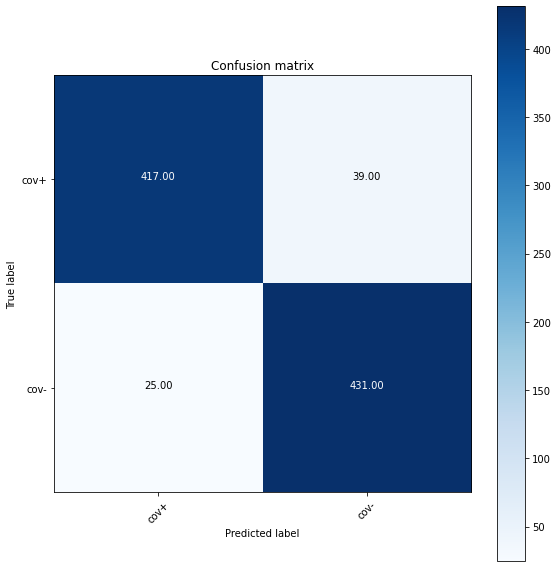

In [16]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,image_datasets['test'].classes)